In [1]:
pip install xgboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.0 MB/s eta 0:00:00


In [2]:
#importing necessary libraries
import pandas as pd
import numpy as np

#for visualization
import matplotlib.pyplot as plt
import seaborn as sn

#for modelling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
import optuna
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load the dataset
df = pd.read_csv('/content/drive/MyDrive/Projects/faults.csv')

#Basic understanding of data and Preprocessing

In [5]:
#To check how big the dataset is
df.shape

(1941, 34)

In [6]:
#To check how the data looks like
df.sample(5)

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
1751,54,75,2344077,2344153,838,67,80,85442,90,119,...,0.7237,-0.2034,0.9998,0,0,0,0,0,0,1
1341,827,834,1930709,1930720,56,11,11,6337,97,132,...,0.3636,-0.1159,0.1822,0,0,0,0,0,0,1
160,37,53,50442,50467,226,33,31,25563,100,132,...,0.3600,-0.1163,0.6574,0,1,0,0,0,0,0
123,1395,1407,1108752,1108782,264,26,30,25531,64,126,...,0.6000,-0.2445,0.5951,1,0,0,0,0,0,0
1319,798,808,225718,225742,170,23,24,21545,118,141,...,0.5833,-0.0099,0.3977,0,0,0,0,0,0,1


In [7]:
#To know the column names
df.columns

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

In [8]:
'''In the dataset the last 7 columns represent fault classes so will convert the 7 columns into a single one and drop the unnecessary columns.
Checking if any row has multiple fault labels'''

target_columns = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

def check_multilabel(df, target_columns):
    multilabel_rows = df[target_columns].sum(axis=1) > 1
    if multilabel_rows.any():
        print("This is a multi-label classification problem.")
        print(f"Total multi-label rows: {multilabel_rows.sum()}")
    else:
        print("This is a multi-class classification problem.")

check_multilabel(df,target_columns)

This is a multi-class classification problem.


In [9]:
#Converting into single column
df['Fault_type'] = df[target_columns].idxmax(axis = 1)
df=df.drop(target_columns, axis=1)
df.sample(5)
print(df.shape)

(1941, 28)


In [10]:
# To know datatype of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 non-null   float64
 15  Empt

In [11]:
#Checking for unique values
df.nunique()

,0
X_Minimum,962
X_Maximum,994
Y_Minimum,1939
Y_Maximum,1940
Pixels_Areas,920
X_Perimeter,399
Y_Perimeter,317
Sum_of_Luminosity,1909
Minimum_of_Luminosity,161
Maximum_of_Luminosity,100


In [12]:
print(df['Outside_Global_Index'].unique())
print(df['Steel_Plate_Thickness'].unique())

[1.  0.5 0. ]
[ 80 100 290 185  40 150 200  50  70 250  60  69 120 211 143 220 175 125
  90  85 300 180 130 140]


In [13]:
# types_of_steel_columns are categorical which is onehotencoded
# Rename multiple columns
df.rename(columns={'TypeOfSteel_A300': 'A300', 'TypeOfSteel_A400': 'A400'}, inplace=True)

#Converting the 2 type of steel column into a single one
type_of_steel = ['A300','A400']
df['Steel_type'] = df[type_of_steel].idxmax(axis = 1)
df=df.drop(type_of_steel, axis=1)
df.shape

(1941, 27)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  Steel_Plate_Thickness  1941 non-null   int64  
 12  Edges_Index            1941 non-null   float64
 13  Empty_Index            1941 non-null   float64
 14  Square_Index           1941 non-null   float64
 15  Outs

In [15]:
#Checking if is there any duplicate values
df.duplicated().sum()

np.int64(0)

In [16]:
#Checking for missing values
df.isnull().sum()/len(df)*100

,0
X_Minimum,0.0
X_Maximum,0.0
Y_Minimum,0.0
Y_Maximum,0.0
Pixels_Areas,0.0
X_Perimeter,0.0
Y_Perimeter,0.0
Sum_of_Luminosity,0.0
Minimum_of_Luminosity,0.0
Maximum_of_Luminosity,0.0


We can see that there is no missing value present in the dataset

In [17]:
#Separating categorical and numerical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

#Exploratory Data Analysis(EDA)

In [18]:
#Checking how the data looks like mathematically
df.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,1941.000000,1941.000000,1.941000e+03,1.941000e+03,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,...,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,571.136012,617.964451,1.650685e+06,1.650739e+06,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,130.193715,...,0.033361,0.610529,0.813472,0.575734,2.492388,1.335686,1.403271,0.083288,-0.131305,0.585420
std,520.690671,497.627410,1.774578e+06,1.774590e+06,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,18.690992,...,0.058961,0.243277,0.234274,0.482352,0.788930,0.481612,0.454345,0.500868,0.148767,0.339452
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,...,0.001500,0.014400,0.048400,0.000000,0.301000,0.301000,0.000000,-0.991000,-0.998900,0.119000
25%,51.000000,192.000000,4.712530e+05,4.712810e+05,84.000000,15.000000,13.000000,9.522000e+03,63.000000,124.000000,...,0.006600,0.411800,0.596800,0.000000,1.924300,1.000000,1.079200,-0.333300,-0.195000,0.248200
50%,435.000000,467.000000,1.204128e+06,1.204136e+06,174.000000,26.000000,25.000000,1.920200e+04,90.000000,127.000000,...,0.010100,0.636400,0.947400,1.000000,2.240600,1.176100,1.322200,0.095200,-0.133000,0.506300
75%,1053.000000,1072.000000,2.183073e+06,2.183084e+06,822.000000,84.000000,83.000000,8.301100e+04,106.000000,140.000000,...,0.023500,0.800000,1.000000,1.000000,2.914900,1.518500,1.732400,0.511600,-0.066600,0.999800
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,...,0.875900,1.000000,1.000000,1.000000,5.183700,3.074100,4.258700,0.991700,0.642100,1.000000


In [19]:
#Checking the skewness
df.select_dtypes(include=['float64', 'int64']).skew()

,0
X_Minimum,0.500897
X_Maximum,0.524210
Y_Minimum,2.811213
Y_Maximum,2.811169
Pixels_Areas,14.083822
X_Perimeter,21.539451
Y_Perimeter,39.293158
Sum_of_Luminosity,7.730720
Minimum_of_Luminosity,-0.107098
Maximum_of_Luminosity,1.287035


In [20]:
#Applying transformations
df['Pixels_Areas'] = np.log1p(df['Pixels_Areas'])
df['X_Perimeter'] = np.log1p(df['X_Perimeter'])
df['Y_Perimeter'] = np.log1p(df['Y_Perimeter'])
df['Sum_of_Luminosity'] = np.log1p(df['Sum_of_Luminosity'])
df['Outside_X_Index'] = np.log1p(df['Outside_X_Index'])
df['Outside_Global_Index'] = np.log1p(df['Outside_Global_Index'])
df['Steel_Plate_Thickness'] = np.log1p(df['Steel_Plate_Thickness'])

In [21]:
df.select_dtypes(include=['float64', 'int64']).skew()

,0
X_Minimum,0.500897
X_Maximum,0.524210
Y_Minimum,2.811213
Y_Maximum,2.811169
Pixels_Areas,0.767502
X_Perimeter,0.880018
Y_Perimeter,0.706116
Sum_of_Luminosity,0.787480
Minimum_of_Luminosity,-0.107098
Maximum_of_Luminosity,1.287035


In [22]:
#Checking whether there is outliers present or not
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    outliers = series[(series < Q1 - 1.5 * IQR) | (series > Q3 + 1.5 * IQR)]
    return outliers

In [23]:
for i in num_cols:
    outliers = detect_outliers_iqr(df[i])
    print(f"Number of outliers in {i}: {len(outliers)}")

Number of outliers in X_Minimum: 0
Number of outliers in X_Maximum: 0
Number of outliers in Y_Minimum: 81
Number of outliers in Y_Maximum: 81
Number of outliers in Pixels_Areas: 4
Number of outliers in X_Perimeter: 7
Number of outliers in Y_Perimeter: 1
Number of outliers in Sum_of_Luminosity: 25
Number of outliers in Minimum_of_Luminosity: 20
Number of outliers in Maximum_of_Luminosity: 146
Number of outliers in Length_of_Conveyer: 0
Number of outliers in Steel_Plate_Thickness: 47
Number of outliers in Edges_Index: 0
Number of outliers in Empty_Index: 20
Number of outliers in Square_Index: 0
Number of outliers in Outside_X_Index: 370
Number of outliers in Edges_X_Index: 0
Number of outliers in Edges_Y_Index: 0
Number of outliers in Outside_Global_Index: 0
Number of outliers in LogOfAreas: 6
Number of outliers in Log_X_Index: 34
Number of outliers in Log_Y_Index: 4
Number of outliers in Orientation_Index: 0
Number of outliers in Luminosity_Index: 134
Number of outliers in SigmoidOfArea

Some of the features has outliers hence outliers robust algorithms should be used here.

In [24]:
#Checking the distribution of class
df['Fault_type'].value_counts()/len(df)*100

,count
Fault_type,
Other_Faults,34.672849
Bumps,20.710974
K_Scatch,20.144256
Z_Scratch,9.788769
Pastry,8.140134
Stains,3.709428
Dirtiness,2.833591


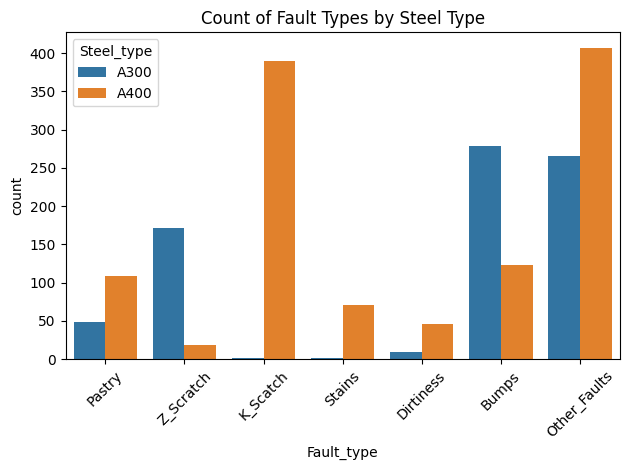

In [25]:
sn.countplot(x='Fault_type', hue='Steel_type', data=df)
plt.title('Count of Fault Types by Steel Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It is an imbalanced dataset(Imbalanced class) which needs to be taken care of.

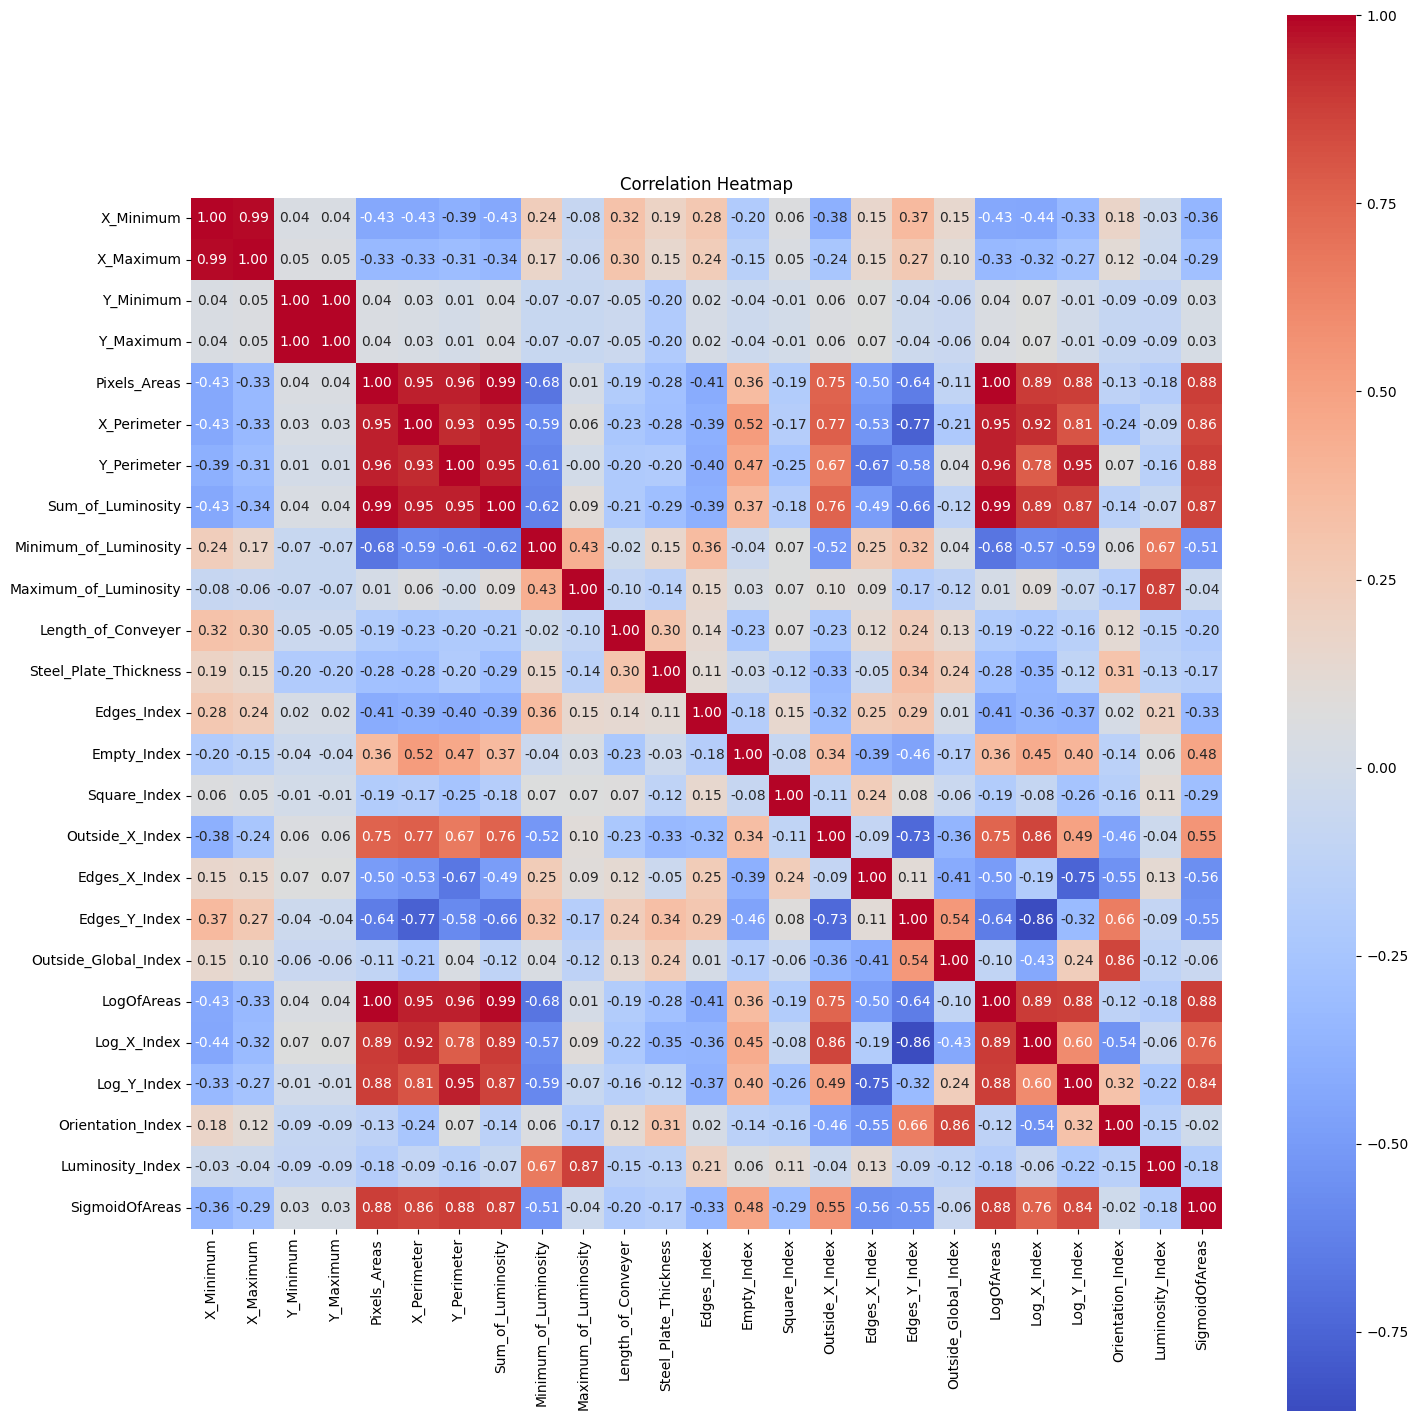

In [26]:
#Correlation matrix
corr = df[num_cols].corr()
plt.figure(figsize=(15, 15))
sn.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

We can see that the features has highly correlated to each other and not sure which features to remove due to lack of domain knowledge. So it is better to use tree based algorithms.

#Model Training, Evaluation, Saving

In [27]:
df.shape

(1941, 27)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   float64
 5   X_Perimeter            1941 non-null   float64
 6   Y_Perimeter            1941 non-null   float64
 7   Sum_of_Luminosity      1941 non-null   float64
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  Steel_Plate_Thickness  1941 non-null   float64
 12  Edges_Index            1941 non-null   float64
 13  Empty_Index            1941 non-null   float64
 14  Square_Index           1941 non-null   float64
 15  Outs

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Fault_type'] = le.fit_transform(df['Fault_type'])
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(label_mapping)

df['Steel_type'] = le.fit_transform(df['Steel_type'])

{'Bumps': 0, 'Dirtiness': 1, 'K_Scatch': 2, 'Other_Faults': 3, 'Pastry': 4, 'Stains': 5, 'Z_Scratch': 6}


In [30]:
#Splitting the features and target
X = df.drop('Fault_type', axis=1)
y = df['Fault_type']

# splitting for traing and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
#Creating model objects
classifiers = {
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "SVM": SVC(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(random_state=42, scale_pos_weight=1, verbosity = 0)
}

# training and evaluating
for name, model in classifiers.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{name} - F1 Score: {f1:.4f}")

Decision Tree - F1 Score: 0.7134
Random Forest - F1 Score: 0.7672
SVM - F1 Score: 0.2410
XGBoost - F1 Score: 0.7643


In [32]:
#Training with kfold cv

classifiers = {
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(random_state=42, scale_pos_weight=1, verbosity = 0)
}


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in classifiers.items():
    cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='f1_weighted')
    print(f"{name} - Mean F1 Score: {np.mean(cv_scores):.4f}")
    print(f"{name} - Standard Deviation: {np.std(cv_scores):.4f}")
    print("-" * 50)

Decision Tree - Mean F1 Score: 0.7066
Decision Tree - Standard Deviation: 0.0098
--------------------------------------------------
Random Forest - Mean F1 Score: 0.7700
Random Forest - Standard Deviation: 0.0139
--------------------------------------------------
XGBoost - Mean F1 Score: 0.8050
XGBoost - Standard Deviation: 0.0114
--------------------------------------------------


In [33]:
#Hyperparameter tuning using optuna

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
num_classes = len(np.unique(y))

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 10),
        'random_state': 42,
        'verbosity': 0,
        'use_label_encoder': False,
        'n_jobs': -1,
        'objective': 'multi:softmax',
        'num_class': num_classes,
        'eval_metric': 'mlogloss'
    }

    model = XGBClassifier(**params)
    scores = cross_val_score(model, X, y, cv=kfold, scoring='f1_weighted')
    return np.mean(scores)

# Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Best trial:")
print(study.best_trial)
print("Best parameters:")
print(study.best_params)

[I 2025-08-21 06:50:52,434] A new study created in memory with name: no-name-182c4ac9-7cd4-4000-a9ac-7ba0f7920646
[I 2025-08-21 06:50:55,641] Trial 0 finished with value: 0.7462035601012307 and parameters: {'n_estimators': 122, 'max_depth': 5, 'learning_rate': 0.04858152454957282, 'subsample': 0.659546235057066, 'colsample_bytree': 0.7457658668191532, 'gamma': 2.625773123757918, 'reg_alpha': 3.984662117775459, 'reg_lambda': 0.9102715689886298, 'scale_pos_weight': 7.562864515115481}. Best is trial 0 with value: 0.7462035601012307.
[I 2025-08-21 06:50:57,397] Trial 1 finished with value: 0.7850846007745801 and parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.23652197930372063, 'subsample': 0.9402859658139913, 'colsample_bytree': 0.9380540294324544, 'gamma': 0.1414150913079093, 'reg_alpha': 0.4356562647402473, 'reg_lambda': 3.8579973620124615, 'scale_pos_weight': 9.052719329593927}. Best is trial 1 with value: 0.7850846007745801.
[I 2025-08-21 06:51:02,437] Trial 2 fini

Best trial:
FrozenTrial(number=11, state=1, values=[0.8014255307386285], datetime_start=datetime.datetime(2025, 8, 21, 6, 51, 29, 267437), datetime_complete=datetime.datetime(2025, 8, 21, 6, 51, 35, 754025), params={'n_estimators': 299, 'max_depth': 3, 'learning_rate': 0.22930878284743397, 'subsample': 0.8608435354822889, 'colsample_bytree': 0.8862769442463345, 'gamma': 0.12941279555892188, 'reg_alpha': 0.03079188877865746, 'reg_lambda': 3.141375466122532, 'scale_pos_weight': 0.7312567845208444}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'max_depth': IntDistribution(high=15, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, step

In [34]:
#Final training on best parameters
best_params = study.best_params
num_classes = len(np.unique(y))
model = XGBClassifier(**best_params, objective='multi:softmax', num_class=num_classes, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"XGBoost (best parameters) - F1 Score: {f1:.4f}")
print(classification_report(y_test,y_pred))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:55:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (best parameters) - F1 Score: 0.7819
              precision    recall  f1-score   support

           0       0.59      0.61      0.60        72
           1       0.67      0.75      0.71         8
           2       0.95      0.96      0.96        83
           3       0.76      0.72      0.74       143
           4       0.62      0.69      0.66        29
           5       1.00      0.92      0.96        13
           6       0.93      0.95      0.94        41

    accuracy                           0.78       389
   macro avg       0.79      0.80      0.79       389
weighted avg       0.78      0.78      0.78       389



In [35]:
import joblib

joblib.dump(model, 'xgboost_model.pkl')
joblib.dump(model, '/content/drive/MyDrive/xgboost_model.pkl')

['/content/drive/MyDrive/xgboost_model.pkl']